# ResNet50

## Setup

In [1]:
!pip install fastai
from fastai.vision import*
from fastai.metrics import error_rate, accuracy

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jun 13 22:10:39 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98                 Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   51C    P8              24W / 270W |   1528MiB /  8192MiB |     16%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
import os
import os.path as op
import shutil
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [5]:
from fastbook import *

In [6]:
import torch
torch.cuda.is_available()

True

## Train~~~

In [7]:
path = Path(r"C:\Users\Msi\Downloads\Added_Cloud_Pic\train")

In [8]:
path.ls()

(#12) [Path('C:/Users/Msi/Downloads/Added_Cloud_Pic/train/Altocumulus'),Path('C:/Users/Msi/Downloads/Added_Cloud_Pic/train/Altostratus'),Path('C:/Users/Msi/Downloads/Added_Cloud_Pic/train/Cirrocumulus'),Path('C:/Users/Msi/Downloads/Added_Cloud_Pic/train/Cirrostratus'),Path('C:/Users/Msi/Downloads/Added_Cloud_Pic/train/Cirrus'),Path('C:/Users/Msi/Downloads/Added_Cloud_Pic/train/Contrails'),Path('C:/Users/Msi/Downloads/Added_Cloud_Pic/train/Cumulonimbus'),Path('C:/Users/Msi/Downloads/Added_Cloud_Pic/train/Cumulus'),Path('C:/Users/Msi/Downloads/Added_Cloud_Pic/train/Nimbostratus'),Path('C:/Users/Msi/Downloads/Added_Cloud_Pic/train/Stratocumulus')...]

In [9]:
from fastai.vision.all import *
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #x - image ; y - single class
    get_items=get_image_files, #get image from selected folder (path) ; return list of pic
    splitter=GrandparentSplitter(train_name = 'train',valid_name='valid'), #use parent folder as train-valid split
    get_y=parent_label, #use parent folder as label 
    item_tfms=Resize(512, method=ResizeMethod.Squish), # Resize image to same size using Squish
    batch_tfms=aug_transforms(size=512, flip_vert=False, pad_mode=PadMode.Reflection, max_lighting=0.2, p_lighting=0.75 )
    )

dls = dblock.dataloaders(r'C:\Users\Msi\Downloads\Added_Cloud_Pic', bs=20 ,shuffle=True)

In [10]:
vc = pd.value_counts(dls.train_ds.items, sort=False)

In [11]:
print(len(dls.train_ds), len(dls.valid_ds))

1936 456


In [12]:
dls.train.vocab

['Altocumulus', 'Altostratus', 'Cirrocumulus', 'Cirrostratus', 'Cirrus', 'Contrails', 'Cumulonimbus', 'Cumulus', 'Nimbostratus', 'Stratocumulus', 'Stratus']

In [13]:
classes = dls.vocab
train_lbls = L(map(lambda x: classes[x[1]], dls.train_ds))
train_label_counter = Counter(train_lbls)

In [14]:
train_label_counter

Counter({'Altocumulus': 186,
         'Altostratus': 163,
         'Cirrocumulus': 183,
         'Cirrostratus': 196,
         'Cirrus': 156,
         'Contrails': 141,
         'Cumulonimbus': 166,
         'Cumulus': 187,
         'Nimbostratus': 203,
         'Stratocumulus': 236,
         'Stratus': 119})

In [15]:
classes = dls.vocab
valid_lbls = L(map(lambda x: classes[x[1]], dls.valid_ds))
valid_label_counter = Counter(valid_lbls)

In [16]:
valid_label_counter

Counter({'Altocumulus': 14,
         'Altostratus': 26,
         'Cirrocumulus': 46,
         'Cirrostratus': 60,
         'Cirrus': 25,
         'Contrails': 42,
         'Cumulonimbus': 43,
         'Cumulus': 26,
         'Nimbostratus': 63,
         'Stratocumulus': 70,
         'Stratus': 41})

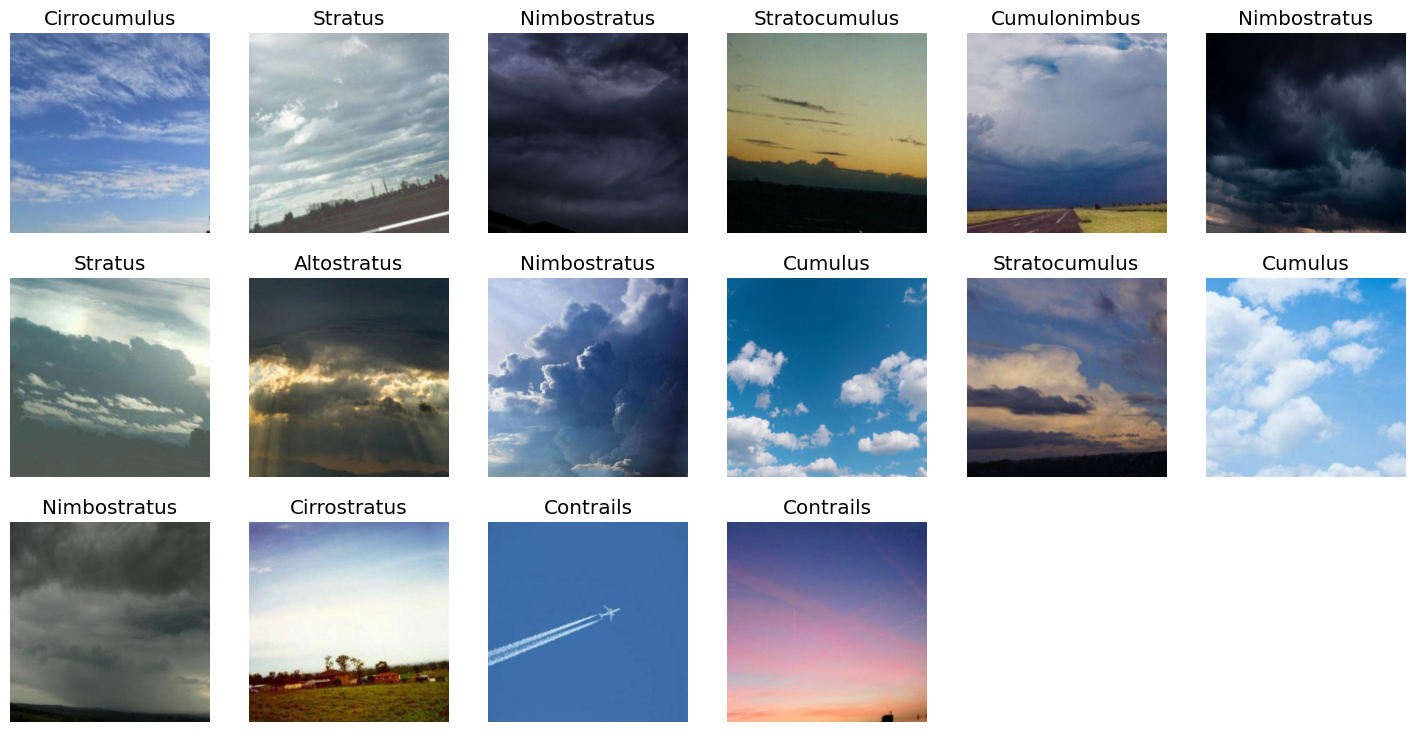

In [17]:
dls.train.show_batch(max_n=16, nrows=3)

In [18]:
learner = cnn_learner(dls, resnet50, metrics=[error_rate, accuracy])

C:\anaconda3\envs\tf_gpu\Lib\site-packages\fastai\vision\learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
C:\anaconda3\envs\tf_gpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\anaconda3\envs\tf_gpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0004786300996784121)

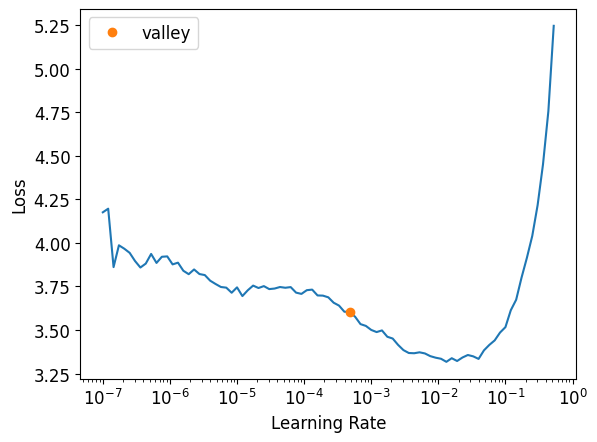

In [98]:
learner.lr_find()

In [99]:
learner.fine_tune(epochs=25,cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=1.8, patience=5), base_lr=0.0004786300996784121)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.722544,2.119709,0.605263,0.394737,11:55


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.143950,1.896051,0.574561,0.425439,13:29
1,1.998926,1.754608,0.543860,0.456140,13:23
2,1.862494,1.759312,0.530702,0.469298,13:26
3,1.772415,1.698369,0.513158,0.486842,15:43
4,1.700972,1.711275,0.502193,0.497807,21:33
5,1.625575,1.692572,0.517544,0.482456,28:27


No improvement since epoch 0: early stopping


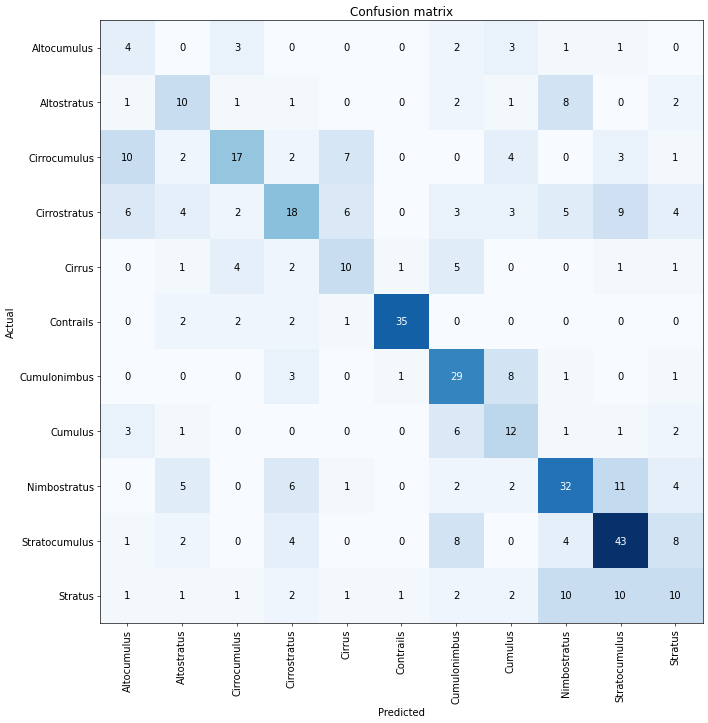

In [100]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [101]:
interp.print_classification_report()

               precision    recall  f1-score   support

  Altocumulus       0.15      0.29      0.20        14
  Altostratus       0.36      0.38      0.37        26
 Cirrocumulus       0.57      0.37      0.45        46
 Cirrostratus       0.45      0.30      0.36        60
       Cirrus       0.38      0.40      0.39        25
    Contrails       0.92      0.83      0.88        42
 Cumulonimbus       0.49      0.67      0.57        43
      Cumulus       0.34      0.46      0.39        26
 Nimbostratus       0.52      0.51      0.51        63
Stratocumulus       0.54      0.61      0.58        70
      Stratus       0.30      0.24      0.27        41

     accuracy                           0.48       456
    macro avg       0.46      0.46      0.45       456
 weighted avg       0.50      0.48      0.48       456



In [102]:
interp.most_confused(min_val=3)

[('Nimbostratus', 'Stratocumulus', 11),
 ('Cirrocumulus', 'Altocumulus', 10),
 ('Stratus', 'Nimbostratus', 10),
 ('Stratus', 'Stratocumulus', 10),
 ('Cirrostratus', 'Stratocumulus', 9),
 ('Altostratus', 'Nimbostratus', 8),
 ('Cumulonimbus', 'Cumulus', 8),
 ('Stratocumulus', 'Cumulonimbus', 8),
 ('Stratocumulus', 'Stratus', 8),
 ('Cirrocumulus', 'Cirrus', 7),
 ('Cirrostratus', 'Altocumulus', 6),
 ('Cirrostratus', 'Cirrus', 6),
 ('Cumulus', 'Cumulonimbus', 6),
 ('Nimbostratus', 'Cirrostratus', 6),
 ('Cirrostratus', 'Nimbostratus', 5),
 ('Cirrus', 'Cumulonimbus', 5),
 ('Nimbostratus', 'Altostratus', 5),
 ('Cirrocumulus', 'Cumulus', 4),
 ('Cirrostratus', 'Altostratus', 4),
 ('Cirrostratus', 'Stratus', 4),
 ('Cirrus', 'Cirrocumulus', 4),
 ('Nimbostratus', 'Stratus', 4),
 ('Stratocumulus', 'Cirrostratus', 4),
 ('Stratocumulus', 'Nimbostratus', 4),
 ('Altocumulus', 'Cirrocumulus', 3),
 ('Altocumulus', 'Cumulus', 3),
 ('Cirrocumulus', 'Stratocumulus', 3),
 ('Cirrostratus', 'Cumulonimbus', 3),


In [103]:
learner.export(r"C:\Users\Msi\Downloads\Cloud_resnet50_fastai.pkl")

## Test Model

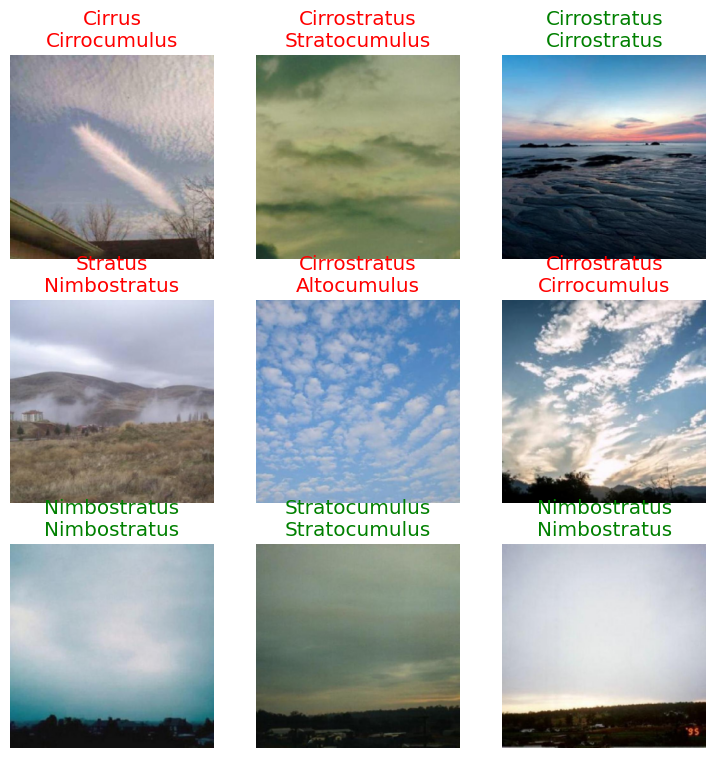

In [104]:
learner.show_results(shuffle=True)

In [7]:
learn = load_learner(r'C:\Users\Msi\Downloads\Cloud_resnet50_fastai.pkl')